In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import scipy

In [26]:
#import data for  stocks that I personally have held over the past year
apple = yf.download("AAPL",start='2023-04-06', end = datetime.now(),auto_adjust=True)
ibm = yf.download("IBM",start='2023-04-06', end = datetime.now(),auto_adjust=True)
arm = yf.download("ARM",start='2023-04-06', end = datetime.now(),auto_adjust=True)
rollsroyce = yf.download("RR.L",start='2023-04-06', end = datetime.now(),auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:
myStocks = pd.concat([apple['Close'],ibm['Close'],arm['Close'],rollsroyce['Close']],axis=1)
logReturns = np.log(myStocks/myStocks.shift(1)).dropna()

Ticker,AAPL,IBM,ARM,RR.L
Date,,,,
2023-09-15,-0.004163,-0.009273,-0.045689,0.007061
2023-09-18,0.016772,-0.006184,-0.046324,-0.013280
2023-09-19,0.006162,0.009808,-0.050024,0.007105
2023-09-20,-0.020195,0.022339,-0.041827,-0.010229
2023-09-21,-0.008929,-0.016487,-0.014276,-0.014862
...,...,...,...,...
2025-08-28,0.008941,0.003628,0.013347,0.001891
2025-08-29,-0.001808,-0.009157,-0.030195,0.010806
2025-09-03,0.037382,0.010709,-0.006976,0.012088


In [43]:
n = len(logReturns.columns)

In [44]:
def generateWeights(n):
    weights = np.random.random(n)
    weights = weights/np.sum(weights)

    return weights

In [47]:
def calculateReturns(logReturns,weights):
    annualisedLogRets = np.sum(logReturns.mean()*weights)*252
    return annualisedLogRets

In [52]:
def calculateVolatility(logReturns,weights):
    volatility = weights.T @ (logReturns.cov()*252 @ weights)
    return volatility

In [61]:
weightsList = []
returnsList = []
volatilityList = []

for sim in range(6000):
    weights = generateWeights(n)
    weightsList.append(weights)
    returnsList.append(calculateReturns(logReturns,weights))
    volatilityList.append(calculateVolatility(logReturns,weights))


sharpeRatios = (np.array(returnsList) - 0.041)/np.array(volatilityList)


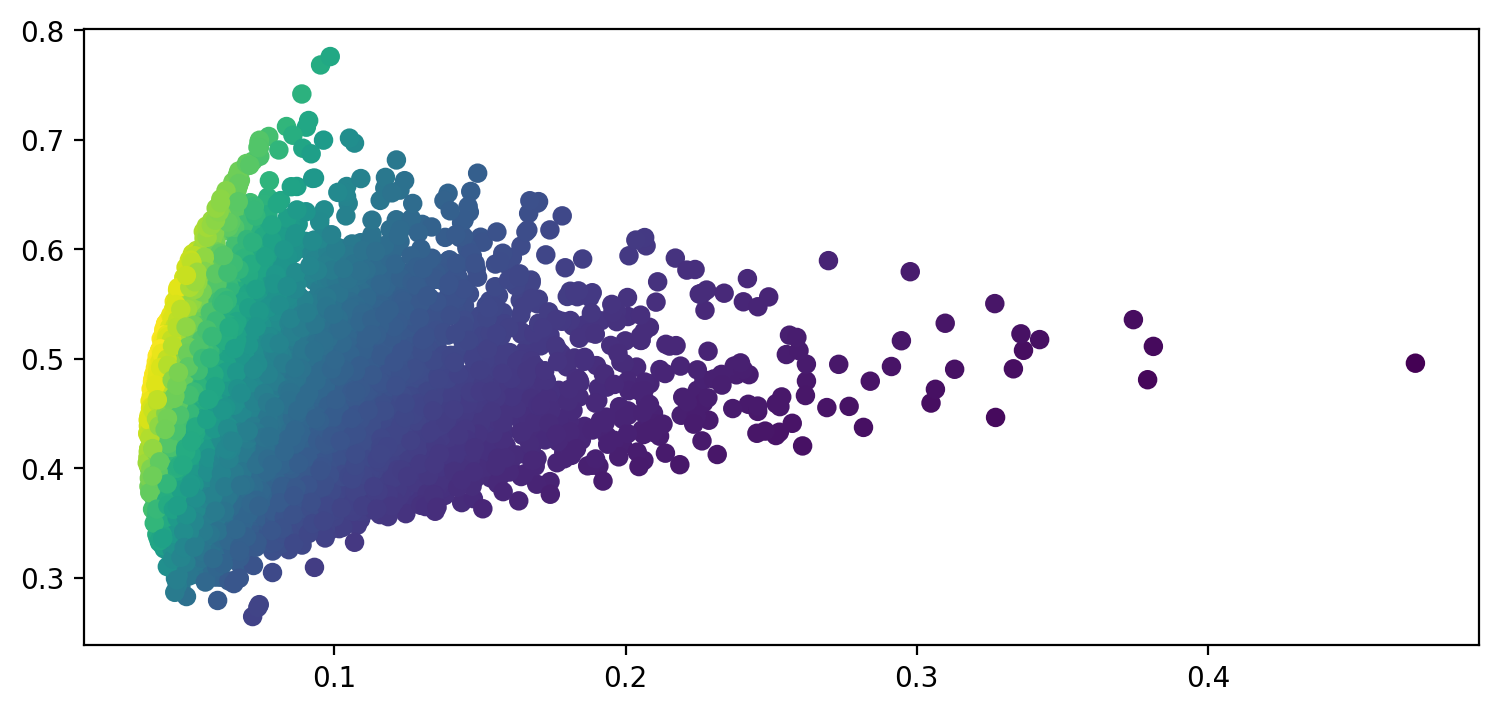

In [62]:
plt.figure(dpi=200,figsize=(9,4))
plt.scatter(volatilityList,returnsList,c=sharpeRatios)

In [ ]:
def functionToMinimize(weights):
    return -1*sharpeRatios

bounds = tuple((0,1)  for n in range(n))
startguess = [1/n for n in range(n)]
sum_constraint = 
